<h1> DS200A Computer Vision Assignment</h1>

<h2>  Part Two: Feature extraction. </h2>	


In [138]:
#Import anything you need here
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import matplotlib.patheffects as PathEffects
import skimage
from skimage import data
from skimage import io
import os
import pickle
import seaborn as sns
import cv2 #3.4.2
import PIL
import scipy

# import skimage.filter
from skimage import filters
from skimage import feature
from skimage.io import imread, imshow
from skimage.filters import prewitt_h,prewitt_v
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.filters import gaussian

from skimage.feature import daisy
from skimage import data


import random
from random import shuffle
import time

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Speed up pandas 
#https://www.kdnuggets.com/2019/11/speed-up-pandas-4x.html

# import ray
# ray.init(num_cpus=4)
# import modin.pandas as pd

In [4]:
# import dask.dataframe as dd
# import multiprocessing

In [3]:
cv2.__version__

'3.4.2'

<h3> Read in data

In [4]:
starting_data = pd.read_pickle('./starting_data.pkl')
starting_data.head()

,image,label
0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0
1,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0
2,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0
3,"[[[174, 190, 187], [173, 189, 186], [172, 188,...",0
4,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0


<h3> Image Preprocessing: Fill in missing RGB values

In [1]:
#Find rows with missing RGB channels, aka Black and White images.
#Helper for bw_to_rgb
def find_missing(df):
    missing = []
    for ind in df.index: 
        if len(df.image[ind].shape)<3:
            missing.append(ind)
    return missing
find_missing(starting_data)[13] #get one value

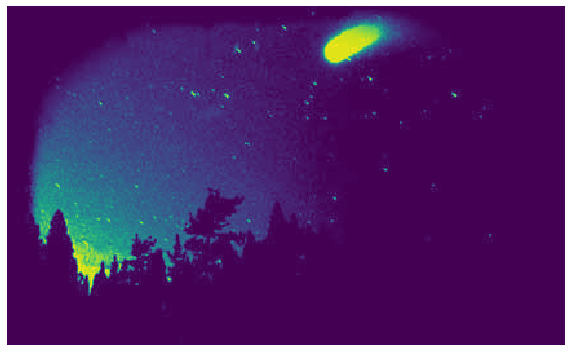

In [6]:
#Visualize images with missing RGB channels
fig, ax = plt.subplots(figsize=(10,10))
ax.axis('off')
ax.imshow(starting_data.image[210])

In [7]:
#View labels for BW images
starting_data.loc[find_missing(starting_data)].label.value_counts

<bound method IndexOpsMixin.value_counts of 169    2
210    3
215    3
217    3
225    3
240    3
242    3
245    3
253    3
256    3
257    3
261    3
262    3
330    4
435    6
740    9
Name: label, dtype: object>

In [8]:
starting_data.loc[find_missing(starting_data)].label.value_counts()

3    12
6     1
4     1
2     1
9     1
Name: label, dtype: int64

In [9]:
12/len(starting_data[starting_data['label']==3])*100

14.814814814814813

<h4> We see only 3 BW images are not in class 3 - this means if we simply drop the images, we lose many images for class 3 (~15%). Instead, we impute missing rgb values using cv2.

In [13]:
#Find rows with missing RGB channels, aka Black and White images.
#Convert 2 BW channels to 3 RGB channels.
#Return modified df with new channels.
def bw_to_rgb(df):
    """
    https://stackoverflow.com/questions/21596281/how-does-one-convert-a-grayscale-image-to-rgb-in-opencv-python-for-visualizing
    """
    missing = find_missing(df)
#     print(missing)
    for i in range(len(missing)):
        image = df.image[missing[i]]
#         print(df.image[missing[i]])
#         print(df.image[missing[i]].shape)
        torgb = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
#         cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        assert(len(torgb.shape))==3
        df.image[missing[i]]=torgb
#     print(df.image[missing[i]].shape)
    return df

In [11]:
#Call function to fill in missing RGB channels
starting_data = bw_to_rgb(starting_data)

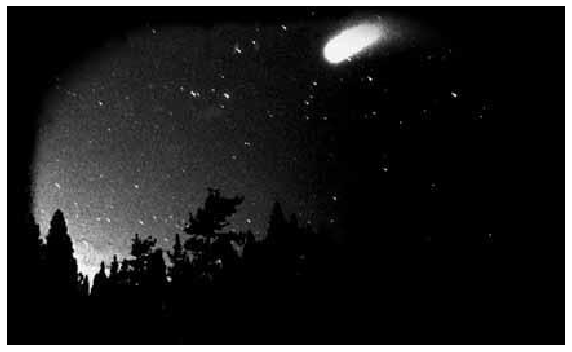

In [12]:
#Visualize images with imputed RGB channels; make sure they show up BW
fig, ax = plt.subplots(figsize=(10,10))
ax.axis('off')
ax.imshow(starting_data.image[210])

In [19]:
#Testing pieces
copy = starting_data.copy()
dat  = copy.loc[260:265]
test = copy.image[242]
grayscale = rgb2gray(test)

dat
#20 plane
#3: airplane
#800: kangaroo
#680: ape
#420: dolphin

#620 weird image!!
#242: missing index 3 comet_0038.jpg
#169: missing index 3 blimp_0022.jpg


,image,label
260,"[[[1, 1, 1], [2, 2, 2], [2, 2, 2], [2, 2, 2], ...",3
261,"[[[173, 173, 173], [175, 175, 175], [178, 178,...",3
262,"[[[47, 47, 47], [44, 44, 44], [37, 37, 37], [3...",3
263,"[[[32, 36, 37], [21, 25, 26], [8, 12, 13], [2,...",3
264,"[[[134, 146, 228], [125, 137, 219], [122, 133,...",3
265,"[[[0, 3, 74], [1, 5, 79], [3, 6, 85], [3, 5, 9...",3


<h3>Image Feature Methods

<h5> In this section, Compute at least 15 such image features (a method for each), including the following (NOTE: At least 10 of these must be scalar features and 2 matrix-based features): (i) image size, (ii) average of the red-channel intensity, (iii) aspectratio. This will require significant explatoratory research and data analysis. The first one is already implemented for you, and the next two are pre-specified. Additional requirements specfied in pdf. </h5>

In [16]:
def size(image): 
    return image.size

def aspect_ratio(image): 
    """
    Returns the aspect ratio of the image
    """
    return image.shape[1]/image.shape[0]

def r_mean(image):
    """
    Mean pixel value of red channels
    """
    return np.mean(image[:,:,0])

def r_std(image):
    """
    SD pixel value of red channels
    """
    return np.std(image[:,:,0])

def g_mean(image): 
    """
    Mean pixel value of green channels
    """
    return np.mean(image[:,:,1])


def g_std(image): 
    """
    Mean pixel value of green channels
    """
    return np.std(image[:,:,1])

def b_mean(image): 
    """
    Mean pixel value of blue channels
    """
    return np.mean(image[:,:,2])

def b_std(image): 
    """
    SD pixel value of blue channels
    """
    return np.std(image[:,:,2])

def luminance_mean(image):
    """
    Mean value of luminance (Y)
    """
    image = skimage.color.rgb2ycbcr(image)
    return np.mean(image[:, :, 0])

def luminance_std(image):
    """
    SD of luminance (Y)
    """
    image = skimage.color.rgb2ycbcr(image)
    return np.std(image[:, :, 0])
    
def cb_mean(image):
    """
    Mean value of blue chroma component (Cb)
    """
    image = skimage.color.rgb2ycbcr(image)
    return np.mean(image[:, :, 1])
def cb_std(image):
    """
    SD of blue chroma component (Cb)
    """
    image = skimage.color.rgb2ycbcr(image)
    return np.std(image[:, :, 1])

def cr_mean(image):
    """
    Mean value of red chroma component (Cb)
    """
    image = skimage.color.rgb2ycbcr(image)
    return np.mean(image[:, :, 2])
def cr_std(image):
    """
    SD value of red chroma component (Cb)
    """
    image = skimage.color.rgb2ycbcr(image)
    return np.std(image[:, :, 2])


def fast_corner(image): 
    """
    FAST (Features from Accelerated Segment Test) Algorithm for Corner Detection
    High-speed performance

    Not robust to high levels of noise. It is dependant on a threshold.
    
    1. Select a pixel p in the image which is to be identified as an interest point or not. Find its intensity, Ip. 
    2. Select appropriate threshold value, t.
    3. Consider a circle of 16 pixels around the pixel.
    4. p is a corner if there exists a set of n contiguous pixels in the circle (of 16 pixels) 
    which are all brighter than Ip + t, or all darker than Ip - t
        For speed,first compare the intensity of pixels at cardinal directions of the circle around Ip. 
        If at least three of the pixels are above or below Ip + t, 
        then check for all 16 pixels and check if 12 contiguous pixels fall in the criterion.
        Else, not an interest point.
        
    Detecting multiple interest points in adjacent locations, use Non-maximum Suppression
    
    https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_fast/py_fast.html
    """
    # Image = cv2.imread(image,0)
    # Initiate FAST object with default values
    fast = cv2.FastFeatureDetector_create()
    # find and draw the keypoints
    kp = fast.detect(image,None)
    # Disable nonmaxSuppression
    fast.setNonmaxSuppression(0)
    kp = fast.detect(image,None)
    return len(kp)

def brief(image):
    """
    BRIEF (Binary Robust Independent Elementary Features)
    SIFT uses 128-dim vector for descriptors, or 512 bytes, as it uses floating point numbers. 
    Similarly SURF also takes minimum of 256 bytes (for 64-dim). Creating such a vector for 
    thousands of features takes a lot of memory, which is not as reasonable with resource constraints, 
    and takes longer.
    
    BRIEF finds binary strings but skips the step of finding descriptors and thus large vectors.
    It takes smoothened image patches and selects a set of n_d (x,y) location pairs in an unique way, 
    then performs some pixel intensity comparisons on these location pairs. 
    
    BRIEF is a faster method feature descriptor calculation and matching, with high recognition rate.
    
    https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_brief/py_brief.html?highlight=brief
    """
    # Initiate FAST detector
    star = cv2.xfeatures2d.StarDetector_create()
    # Initiate BRIEF extractor
    brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()
    # find the keypoints with STAR
    kp = star.detect(image,None)
    # compute the descriptors with BRIEF
    kp, des = brief.compute(image, kp)
    return len(kp)

def orb(image): 
    """
    ORB (Oriented FAST and Rotated BRIEF)
    ORB is a fusion of FAST keypoint detector and BRIEF descriptor, with modifications for performance. 
    First it use FAST to find keypoints, then applies Harris corner measure to find top N points among them. 
    It also uses pyramid to produce multiscale-features. 
    
    ORB is much faster than SURF and SIFT and ORB descriptor works better than SURF. 
    ORB is a good choice in low-power devices, us in this case.
    """
    
    orb = cv2.ORB_create()
    # find the keypoints with ORB
    kp = orb.detect(image,None)
    # compute the descriptors with ORB
    kp, des = orb.compute(image, kp)
#     # draw only keypoints location,not size and orientation
#     img2 = cv2.drawKeypoints(test, kp, None, color=(0,255,0), flags=0)
#     plt.imshow(img2), plt.show()
    return len(kp)

def sift(image): 
    """
    SIFT (Scale Invariant Feature Transform)
    There are 4 key steps:
    1) Scale-space Extrema Detection: scale-space filtering is used. 
    Difference of Gaussians is found, acting as a blob detector for various sizes due to change in sigma. 
    Difference of Gaussian is obtained as the difference of Gaussian blurring of an image with two different sigma values.
    Once this DoG are found, images are searched for local extrema, which are potential keypoints.
    2) Keypoint Localization
    Taylor series expansion of scale space is used to get more accurate location of extrema.
    If the intensity at this extrema is less than a threshold value (0.03 as per the paper), it is rejected.
    DoG has higher response for edges, so edges need to be removed.
    Eliminate any low-contrast keypoints and edge keypoints to get strong interest points.
    3) Orientation Assignment
    An orientation is assigned to each keypoint to achieve invariance to image rotation. 
    A neighborhood around each kepoint is taken, and gradient magnitude and and direction are calculated.
    A weighted orientation histogram is created. The highest peak in the histogram, and any peak above 80%
    is also considered to calculate the orientation.
    4) KEYPOINT DESCRIPTOR
    A 16x16 neighbourhood around the keypoint is taken, with 16 sub-blocks of 4x4 size. 
    For each sub-block, 8 bin orientation histogram is created.
    128 bin values are available. It is represented as a vector to form keypoint descriptor.
    5) Keypoint Matching
    Keypoints between two images are matched by identifying their nearest neighbours
    https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_sift_intro/py_sift_intro.html
  
    """
    # Image = cv2.imread(image)
    Operated_Image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    kp = sift.detect(Operated_Image,None)
    kp, des = sift.detectAndCompute(Operated_Image,None)
    return len(kp) #pd.Series((len(kp), len(des)))

#     return [len(kp), len(des)] # kp is keypoints and des is descriptors

def surf(image): 
    """
    SURF (Speeded-Up Robust Features) 
    Speeded-up version of SIFT, 3 times faster than SIFT while performance is comparable
    SURF is good at handling images with blurring and rotation, 
    but not good at handling viewpoint change and illumination change
    https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_surf_intro/py_surf_intro.html
    """
# Create SURF object. You can specify params here or later.
# Here I set Hessian Threshold to 400
    surf = cv2.xfeatures2d.SURF_create(400)
# Find keypoints and descriptors directly
    kp, des = surf.detectAndCompute(image,None)
    return len(kp) # kp is keypoints and des is descriptors , len(des)]

def feature_avg_hog(image):#TAKES TOO LONG, exclude
    """
    Compute mean Histogram of Oriented Gradients (HOG) flattened vector
    """
#     return skimage.feature.hog(image).mean()
    return skimage.feature.hog(image).mean()

def daisy_features(image): # TAKES TOO LONG, exclude
    """
    Compute Daisy Features, Boolean
    """
    grayscale = rgb2gray(image)
#     descs = skimage.feature.daisy(grayscale, step=180, radius=58, rings=2, histograms=6,
#                          orientations=8, visualize=True)
    descs = skimage.feature.daisy(grayscale, step=180, radius=50, rings=2, histograms=6,
                         orientations=8, visualize=True)
    return descs

def canny_edges(image): 
    """
    Compute Canny Edges
    Probably the most commonly used and most effective edge detection method.
    1. Noise Reduction: Reduce noise with a 5x5 Gaussian filter
    2. Finding Intensity Gradient of the Image:
    Filter with a Sobel or Prewit kernel in both horizontal and vertical direction to 
    get first derivatives, used to compute edge gradient magnitude and direction, per pixel.
    3. Extract Edge Points with Non-maximum Supression: 
    Full scan of imageto remove any unwanted pixels which may not constitute the edge. 
    Every pixel is checked if it is a local maximum in its neighborhood in the direction of gradient.  
    If not, it is supressed to 0. This step results in a binary image with "thin edges"
    4. Linking and Thresholding with Hysteresis: decide which are all edges are really edges and which are not.
    Any edges with:
        1. intensity gradient >maxVal are sure to be edges
        2. <minVal are discarded as non-edges
        3. minVal<edge<maxVal: If connected to “sure-edge” pixels, edges. Else, discard.
    Also removes small pixels noises on the assumption that edges are long lines
    Final result: strong edges of image
    

    https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_canny/py_canny.html?highlight=canny%20edges
    """
    grayscale = rgb2gray(image)
    edges=skimage.feature.canny(grayscale, sigma=2)
    return (edges*1)

def prewitt_edges(image): 
    """
    Extracting Edge features
    Prewitt is used for detecting vertical and horizontal edges in images, 
    without placing emphasis on the pixels that are closer to the center of the mask. 
    Convolve the image with a small, separable, and integer valued filter, 
    providing differentiating (for edge response) and smoothing (reducing noise).

    SOURCE: 
    https://www.analyticsvidhya.com/blog/2019/08/3-techniques-extract-features-from-image-data-machine-learning-python/
    """
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #calculating horizontal edges using prewitt kernel
    edges_prewitt_horizontal = prewitt_h(gray_image)
    #calculating vertical edges using prewitt kernel
    edges_prewitt_vertical = prewitt_v(gray_image)

    return [edges_prewitt_horizontal,edges_prewitt_vertical]

def binarize(image): 
    """
    Binarizing image after Gray scaling is richer than just binarizing,
    as it shows the image as a combination of different intensities of Gray. 
    Binarizing simply builds a matrix full of 0s and 1s.
    """
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = threshold_otsu(gray_image)
    binary = gray_image > thresh
    return (binary*1) # this is a matrix based feature

def blur(image): 
    """
    Multi-dimensional Gaussian Filter for blurring.
    Blurring algorithm takes weighted average of neighbouring pixels
    to incorporate surroundings color into every pixel. 
    """
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred_image = skimage.filters.gaussian(gray_image,sigma=20)
    return blurred_image

def harris(image):
    """
    Harris Corner Detection
    Corners are regions in the image with large variation in intensity in all the directions. 
    There are 3 cases in change of intensity:

    Flat region: no change in all directions
    Edge: no change along edge directions
    Corner: significant change in all directions

    Harris measures change of intensity for shifts in windows. 
    For desired very distinctive patches, this will be larger; 
    we maximize the change of intensity function using Taylor Expansion, 
    yielding a matrix form score equation. 
    Eigenvalues are used to determine if the region is corner, edge or flat. 
    Threshold to yield corners.

    https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_features_harris/py_features_harris.html
    """
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray,2,3,0.04)
    #result is dilated for marking the corners, not important
    dst = cv2.dilate(dst,None)

    return image[dst>0.01*dst.max()]
def shi_tomasi(image):
    """
    Shi Tomasi Corner Detection: modified and improved Harris Corner Detection
    https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_shi_tomasi/py_shi_tomasi.html 
    """
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    corners = cv2.goodFeaturesToTrack(gray,25,0.01,10)
    corners = np.int0(corners)
    return corners


In [18]:
def feature_frame(data):
    """
    Apply all feature functions
    """
    s = time.time()
    df = pd.DataFrame()
    df['size'] = data.apply(lambda x: size(x[0]), axis=1)
    
    df['aspect_ratio'] = data.apply(lambda x: aspect_ratio(x[0]), axis = 1)
    e = time.time()
    print("SIZE Feature Generation Time = {}".format(e-s))
    
    df['r_mean'] = data.apply(lambda x: r_mean(x[0]), axis = 1)
    e = time.time()
    print("R MEAN Feature Generation Time = {}".format(e-s))
    
    df['r_std'] = data.apply(lambda x: r_std(x[0]), axis = 1)
    e = time.time()
    print("R STD Feature Generation Time = {}".format(e-s))
    
    df['g_mean'] = data.apply(lambda x: g_mean(x[0]), axis = 1)
    e = time.time()
    print("G MEAN Feature Generation Time Time = {}".format(e-s))
    
    df['g_std'] = data.apply(lambda x: g_std(x[0]), axis = 1)
    e = time.time()
    print("G STD Feature Generation Time Time = {}".format(e-s))
    
    df['b_mean'] = data.apply(lambda x: b_mean(x[0]), axis = 1)
    e = time.time()
    print("B MEAN Feature Generation Time = {}".format(e-s))
    
    df['b_std'] = data.apply(lambda x: b_std(x[0]), axis = 1)
    e = time.time()
    print("B STD Feature Generation Time = {}".format(e-s))
    
    df['luminance_mean'] = data.apply(lambda x: luminance_mean(x[0]), axis = 1)
    df['luminance_std'] = data.apply(lambda x: luminance_std(x[0]), axis = 1)
    e = time.time()
    print("LUMINANCE Feature Generation Time = {}".format(e-s))
    
    df['cb_mean'] = data.apply(lambda x: cb_mean(x[0]), axis = 1)
    df['cb_std'] = data.apply(lambda x: cb_std(x[0]), axis = 1)
    e = time.time()
    print("CB Feature Generation Time = {}".format(e-s))
    
    df['cr_mean'] = data.apply(lambda x: cr_mean(x[0]), axis = 1)
    df['cr_std'] = data.apply(lambda x: cr_std(x[0]), axis = 1)
    e = time.time()
    print("CR Feature Generation Time = {}".format(e-s))
    
    df['fast_corner'] = data.apply(lambda x: fast_corner(x[0]), axis = 1)
    e = time.time()
    print("FAST Feature Generation Timee = {}".format(e-s))
    
    df['brief'] = data.apply(lambda x: brief(x[0]), axis = 1)
    e = time.time() #11.346766948699951
    print("BRIEF Feature Generation Timee = {}".format(e-s))
    
    df['orb'] = data.apply(lambda x: orb(x[0]), axis = 1)
    e = time.time() #14.901576042175293
    print("ORB Feature Generation Time = {}".format(e-s))
    
    df['sift_kp'] = data.apply(lambda x: sift(x[0]), axis = 1)
    e = time.time() #14.901576042175293
    print("SIFT KP Feature Generation Time = {}".format(e-s))
    
    df['surf_kp'] = data.apply(lambda x: surf(x[0]), axis = 1)
    e = time.time() #14.901576042175293
    print("SURF KP Feature Generation Time = {}".format(e-s))

    df['canny_edges'] = data.apply(lambda x: canny_edges(x[0]), axis = 1)
    e = time.time() #123.77750611305237
    print("CANNY Feature Generation Time = {}".format(e-s))
    
    df['prewitt_h'] = data.apply(lambda x: prewitt_edges(x[0])[0], axis = 1)
    e = time.time() #16.622008085250854 
    print("PREWITT EDGES HOR Feature Generation Time = {}".format(e-s))
    df['prewitt_v'] = data.apply(lambda x: prewitt_edges(x[0])[1], axis = 1)
    e = time.time() #16.622008085250854 
    print("PREWITT EDGES VER Feature Generation Time = {}".format(e-s))
    
    df['binarize'] = data.apply(lambda x: binarize(x[0]), axis = 1)
    e = time.time() #2.9614150524139404
    print("BINARIZE Feature Generation Time = {}".format(e-s))
    
    df['harris'] = data.apply(lambda x: harris(x[0]), axis = 1)
    e = time.time() #8.947826862335205
    print("HARRIS Feature Generation Time = {}".format(e-s))
    
    df['shi_tomasi'] = data.apply(lambda x: shi_tomasi(x[0]), axis = 1)
    e = time.time()
    print("SHI TOMASI Feature Generation Time = {}".format(e-s))
    e = time.time() #7.886998176574707
    
    print("FINAL Time = {}".format(e-s))
    return df

In [70]:
starting_data.shape

(1501, 2)

In [66]:
starting_data.head()

,image,label
0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0
1,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0
2,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0
3,"[[[174, 190, 187], [173, 189, 186], [172, 188,...",0
4,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0


In [16]:
#Create features frame
features = feature_frame(starting_data)
features.head()

SIZE Feature Generation Time = 0.1052861213684082
R MEAN Feature Generation Time = 0.5655810832977295
R STD Feature Generation Time = 2.4278552532196045
G MEAN Feature Generation Time Time = 2.842649221420288
G STD Feature Generation Time Time = 4.653338193893433
B MEAN Feature Generation Time = 5.045180082321167
B STD Feature Generation Time = 6.621925115585327
LUMINANCE Feature Generation Time = 26.570298194885254
CB Feature Generation Time = 48.48794913291931
CR Feature Generation Time = 66.99602317810059
FAST Feature Generation Timee = 71.89154005050659
BRIEF Feature Generation Timee = 80.83483815193176
ORB Feature Generation Time = 91.13852715492249
SIFT KP Feature Generation Time = 253.06327414512634
SURF KP Feature Generation Time = 339.3274528980255
CANNY Feature Generation Time = 446.54128217697144
PREWITT EDGES HOR Feature Generation Time = 459.001177072525
PREWITT EDGES VER Feature Generation Time = 473.6182131767273
BINARIZE Feature Generation Time = 481.147891998291
HARRIS

,size,aspect_ratio,r_mean,r_std,g_mean,g_std,b_mean,b_std,luminance_mean,luminance_std,...,brief,orb,sift_kp,surf_kp,canny_edges,prewitt_h,prewitt_v,binarize,harris,shi_tomasi
0,195816,2.426829,183.355727,56.406650,176.750337,64.039966,149.151581,79.648356,166.791454,53.495949,...,38,398,340,266,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[205, 203, 164], [205, 203, 162], [226, 223, ...","[[[166, 116]], [[366, 72]], [[89, 128]], [[59,..."
1,221352,2.179348,210.739822,55.293247,189.280101,74.486619,164.805242,70.417988,181.672576,56.847182,...,52,413,207,203,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[244, 203, 185], [240, 181, 163], [242, 179, ...","[[[324, 87]], [[61, 72]], [[311, 116]], [[238,..."
2,194535,2.381818,170.123787,64.391428,147.788681,68.085443,111.753798,89.914294,145.131762,56.089846,...,25,392,466,317,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[208, 221, 237], [188, 201, 217], [160, 173, ...","[[[319, 72]], [[286, 74]], [[165, 92]], [[296,..."
3,200430,2.311765,152.159752,64.525514,132.648316,62.769907,77.917303,83.412773,129.573314,53.570175,...,32,396,575,382,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[226, 209, 191], [212, 195, 177], [192, 174, ...","[[[52, 93]], [[69, 81]], [[264, 65]], [[297, 6..."
4,208560,2.244318,147.397886,73.855439,150.504790,71.385855,86.252963,94.391311,138.168607,62.001119,...,36,407,592,431,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[214, 217, 200], [234, 237, 220], [255, 255, ...","[[[97, 71]], [[136, 9]], [[107, 6]], [[153, 90..."


In [71]:
features.shape

(1501, 22)

In [72]:
# #Save file 
# features.to_pickle('features.pkl')

In [18]:
#Recode with category labels
code_dict = {0:'airplanes',
1:'bear',
2:'blimp',
3:'comet',
4:'crab',
5:'dog',
6:'dolphin',
7:'giraffe',
8:'goat',
9:'gorilla',
10:'kangaroo',
11:'killer-whale',
12:'leopards',
13:'llama',
14:'penguin',
15:'porcupine',
16:'teddy-bear',
17:'triceratops',
18:'unicorn',
19:'zebra'}

features['categories']=features['label'].map(code_dict)

In [19]:
#check
features.head()

,size,aspect_ratio,r_mean,r_std,g_mean,g_std,b_mean,b_std,luminance_mean,luminance_std,...,sift_kp,surf_kp,canny_edges,prewitt_h,prewitt_v,binarize,harris,shi_tomasi,label,categories
0,195816,2.426829,183.355727,56.406650,176.750337,64.039966,149.151581,79.648356,166.791454,53.495949,...,340,266,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[205, 203, 164], [205, 203, 162], [226, 223, ...","[[[166, 116]], [[366, 72]], [[89, 128]], [[59,...",0,airplanes
1,221352,2.179348,210.739822,55.293247,189.280101,74.486619,164.805242,70.417988,181.672576,56.847182,...,207,203,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[244, 203, 185], [240, 181, 163], [242, 179, ...","[[[324, 87]], [[61, 72]], [[311, 116]], [[238,...",0,airplanes
2,194535,2.381818,170.123787,64.391428,147.788681,68.085443,111.753798,89.914294,145.131762,56.089846,...,466,317,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[208, 221, 237], [188, 201, 217], [160, 173, ...","[[[319, 72]], [[286, 74]], [[165, 92]], [[296,...",0,airplanes
3,200430,2.311765,152.159752,64.525514,132.648316,62.769907,77.917303,83.412773,129.573314,53.570175,...,575,382,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[226, 209, 191], [212, 195, 177], [192, 174, ...","[[[52, 93]], [[69, 81]], [[264, 65]], [[297, 6...",0,airplanes
4,208560,2.244318,147.397886,73.855439,150.504790,71.385855,86.252963,94.391311,138.168607,62.001119,...,592,431,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[214, 217, 200], [234, 237, 220], [255, 255, ...","[[[97, 71]], [[136, 9]], [[107, 6]], [[153, 90...",0,airplanes


In [20]:
# #Save file 
# features.to_pickle('features_labeled.pkl')

<h3> Feature Engineering: Dealing with Feature Matrices

In [ ]:
# features = pd.read_pickle('./features_labeled.pkl') 
# data=features.copy()
# data.head(2)

In [ ]:
#Flatten all matrix-based features
for i in range(0,len(features)):
        data['canny_edges'][i]=data['canny_edges'][i].flatten()
for i in range(0,len(features)):
        data['prewitt_h'][i]=data['prewitt_h'][i].flatten()
for i in range(0,len(features)):
        data['prewitt_v'][i]=data['prewitt_v'][i].flatten()
for i in range(0,len(features)):
        data['binarize'][i]=data['binarize'][i].flatten()
for i in range(0,len(features)):
        data['harris'][i]=data['harris'][i].flatten()
for i in range(0,len(features)):
        data['shi_tomasi'][i]=data['shi_tomasi'][i].flatten()  
        
data.head(2)

In [ ]:
#Summarize matrix-based features as sum or mean
new_data = data.copy()
new_data['canny_edges']=new_data['canny_edges'].apply(lambda x: sum(x))
new_data['prewitt_h']=new_data['prewitt_h'].apply(lambda x: sum(x))
new_data['prewitt_v']=new_data['prewitt_v'].apply(lambda x: sum(x))
new_data['binarize']=new_data['binarize'].apply(lambda x: np.mean(x))
new_data['harris']=new_data['harris'].apply(lambda x: np.mean(x))
new_data['shi_tomasi']=new_data['shi_tomasi'].apply(lambda x: np.mean(x))
new_data.head(2)

In [ ]:
# #Save file 
# new_data.to_pickle('features_flattened.pkl')

 We expect all external sources sited, and significant indication of EDA. 

<h3> Feature Frame Generation for Val Data

In [2]:
#Load in val set
val = pd.read_pickle('./val_data.pkl') 
val.head(2)

,image
0,"[[[80, 79, 74], [56, 55, 50], [54, 53, 48], [4..."
1,"[[[213, 173, 85], [213, 173, 85], [213, 173, 8..."


In [8]:
find_missing(val)

[92, 98, 99, 170, 291, 327, 328, 474, 487, 606, 628]

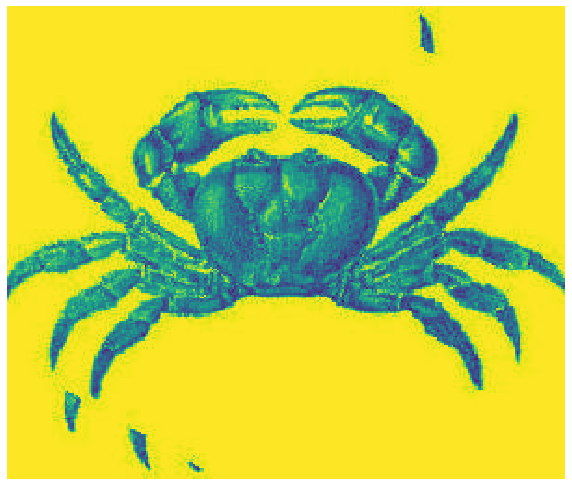

In [11]:
#Visualize images with missing RGB channels
fig, ax = plt.subplots(figsize=(10,10))
ax.axis('off')
ax.imshow(val.image[474])

In [14]:
#Fill in missing RGB channels
val = bw_to_rgb(val)

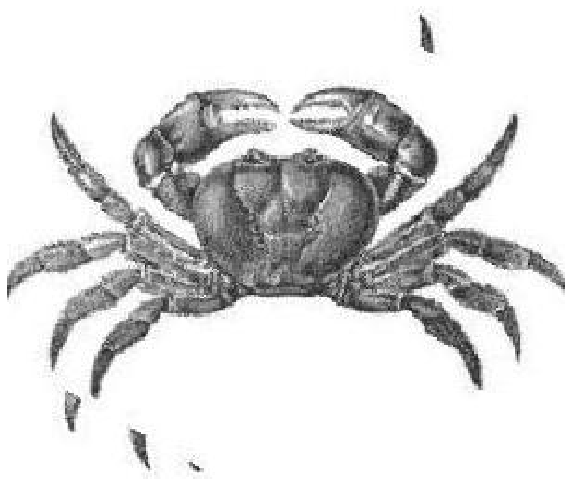

In [15]:
#Visualize images with missing RGB channels; make sure they show up BW
fig, ax = plt.subplots(figsize=(10,10))
ax.axis('off')
ax.imshow(val.image[474])

In [21]:
#Create features frame
val_features = feature_frame(val)

SIZE Feature Generation Time = 0.05235004425048828
R MEAN Feature Generation Time = 0.2486739158630371
R STD Feature Generation Time = 1.0422210693359375
G MEAN Feature Generation Time Time = 1.2830259799957275
G STD Feature Generation Time Time = 1.9711689949035645
B MEAN Feature Generation Time = 2.1269278526306152
B STD Feature Generation Time = 2.7946529388427734
LUMINANCE Feature Generation Time = 12.560304880142212
CB Feature Generation Time = 21.825358867645264
CR Feature Generation Time = 29.97851586341858
FAST Feature Generation Timee = 32.56180787086487
BRIEF Feature Generation Timee = 36.02695870399475
ORB Feature Generation Time = 41.552841901779175
SIFT KP Feature Generation Time = 123.68039774894714
SURF KP Feature Generation Time = 168.39905881881714
CANNY Feature Generation Time = 210.62106585502625
PREWITT EDGES HOR Feature Generation Time = 214.75229287147522
PREWITT EDGES VER Feature Generation Time = 218.84086084365845
BINARIZE Feature Generation Time = 221.00781488

NameError: name 'features' is not defined

In [24]:
val_features.head()
data=val_features.copy()
data.head(2)

,size,aspect_ratio,r_mean,r_std,g_mean,g_std,b_mean,b_std,luminance_mean,luminance_std,...,brief,orb,sift_kp,surf_kp,canny_edges,prewitt_h,prewitt_v,binarize,harris,shi_tomasi
0,1620000,1.500000,105.980433,67.205121,106.905494,65.316848,105.590887,63.113690,107.446701,56.130446,...,898,500,3970,3274,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[108, 103, 107], [156, 151, 155], [165, 161, ...","[[[541, 357]], [[365, 162]], [[243, 351]], [[2..."
1,1279200,1.500938,112.572315,89.033710,101.316091,78.646389,65.335870,60.860931,102.380433,67.857657,...,86,500,580,498,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[188, 161, 92], [174, 144, 80], [166, 136, 74...","[[[671, 295]], [[596, 281]], [[184, 86]], [[28..."


In [26]:
for i in range(0,len(val_features)):
        data['canny_edges'][i]=data['canny_edges'][i].flatten()
for i in range(0,len(val_features)):
        data['prewitt_h'][i]=data['prewitt_h'][i].flatten()
for i in range(0,len(val_features)):
        data['prewitt_v'][i]=data['prewitt_v'][i].flatten()
for i in range(0,len(val_features)):
        data['binarize'][i]=data['binarize'][i].flatten()
for i in range(0,len(val_features)):
        data['harris'][i]=data['harris'][i].flatten()
for i in range(0,len(val_features)):
        data['shi_tomasi'][i]=data['shi_tomasi'][i].flatten()   

/Users/RiRi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/RiRi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/RiRi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/RiRi/opt/anaconda3/l

In [27]:
data.head(2)

,size,aspect_ratio,r_mean,r_std,g_mean,g_std,b_mean,b_std,luminance_mean,luminance_std,...,brief,orb,sift_kp,surf_kp,canny_edges,prewitt_h,prewitt_v,binarize,harris,shi_tomasi
0,1620000,1.500000,105.980433,67.205121,106.905494,65.316848,105.590887,63.113690,107.446701,56.130446,...,898,500,3970,3274,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[108, 103, 107, 156, 151, 155, 165, 161, 162, ...","[541, 357, 365, 162, 243, 351, 246, 77, 236, 7..."
1,1279200,1.500938,112.572315,89.033710,101.316091,78.646389,65.335870,60.860931,102.380433,67.857657,...,86,500,580,498,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[188, 161, 92, 174, 144, 80, 166, 136, 74, 155...","[671, 295, 596, 281, 184, 86, 281, 107, 790, 4..."


In [28]:
new_data = data.copy()
new_data['canny_edges']=new_data['canny_edges'].apply(lambda x: sum(x))
new_data['prewitt_h']=new_data['prewitt_h'].apply(lambda x: sum(x))
new_data['prewitt_v']=new_data['prewitt_v'].apply(lambda x: sum(x))
new_data['binarize']=new_data['binarize'].apply(lambda x: np.mean(x))
new_data['harris']=new_data['harris'].apply(lambda x: np.mean(x))
new_data['shi_tomasi']=new_data['shi_tomasi'].apply(lambda x: np.mean(x))

In [29]:
new_data.head(2)

,size,aspect_ratio,r_mean,r_std,g_mean,g_std,b_mean,b_std,luminance_mean,luminance_std,...,brief,orb,sift_kp,surf_kp,canny_edges,prewitt_h,prewitt_v,binarize,harris,shi_tomasi
0,1620000,1.500000,105.980433,67.205121,106.905494,65.316848,105.590887,63.113690,107.446701,56.130446,...,898,500,3970,3274,38530,-182.307190,54.364706,0.387165,136.623414,259.62
1,1279200,1.500938,112.572315,89.033710,101.316091,78.646389,65.335870,60.860931,102.380433,67.857657,...,86,500,580,498,8127,-737.857516,117.811765,0.409045,106.985920,351.28


In [30]:
# #Save file 
new_data.to_pickle('val_features.pkl')

<h4> For EDA, see EDA_NB </h4>

<h3> For Fun: “Fast & Furious Presents: Features” </h3>


In [ ]:
# FAST: 4.895
# BRIEF: 8.9432
# SURF:  86.26417
# SIFT: 161.9247

# HARRIS: 11.05647
# SHI TOMASI: 8.580357

# ORB: 10.30368
# Canny: 107.21382
# Prewitt V: 14.61703610420227
# Prewitt H: 12.459894895553589


# 2 times faster means two times as fast
# A takes 100 ms
# B takes 200 ms
# so A is two times faster than B

86.26417/8.9432

In [461]:
features = pd.read_pickle('./features_flattened.pkl')
features.head()

,size,aspect_ratio,r_mean,r_std,g_mean,g_std,b_mean,b_std,luminance_mean,luminance_std,...,sift_kp,surf_kp,canny_edges,prewitt_h,prewitt_v,binarize,harris,shi_tomasi,label,categories
0,195816,2.426829,183.355727,56.406650,176.750337,64.039966,149.151581,79.648356,166.791454,53.495949,...,340,266,3819,-194.894118,4.385381e-15,0.513160,121.392454,125.92,0,airplanes
1,221352,2.179348,210.739822,55.293247,189.280101,74.486619,164.805242,70.417988,181.672576,56.847182,...,207,203,1817,-34.841830,-1.143882e+02,0.842771,115.469323,160.38,0,airplanes
2,194535,2.381818,170.123787,64.391428,147.788681,68.085443,111.753798,89.914294,145.131762,56.089846,...,466,317,3755,178.556863,3.996803e-14,0.227126,93.911721,142.00,0,airplanes
3,200430,2.311765,152.159752,64.525514,132.648316,62.769907,77.917303,83.412773,129.573314,53.570175,...,575,382,5270,-252.338562,2.062941e+02,0.212932,110.053966,126.54,0,airplanes
4,208560,2.244318,147.397886,73.855439,150.504790,71.385855,86.252963,94.391311,138.168607,62.001119,...,592,431,4616,-380.200000,-2.003953e-14,0.247828,114.599032,99.30,0,airplanes


In [289]:
# View Label Distribution
display(pd.crosstab(index=features['label'], columns='count'))

col_0,count
label,
0,80
1,68
2,57
3,81
4,57
5,68
6,71
7,56
8,75


In [462]:
#Set plot font parameters
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

# Visualize the outputs of PCA and t-SNE
"""
title_str: desired title (PCA w N components, or TSNE)
x: X
colors: y or target values
lens_lim: xlim and ylim values, as a square w center 0,0
"""
def scatter(title_str, x, colors,lens_lim):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8));
    ax = plt.subplot(aspect='equal');
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)]);

#     ax.axis('off') #toggle on or off for grid
    ax.axis('tight')
   
    # add the labels for each digit corresponding to the label
    txts = []
    for i in range(num_classes):
        # Position of each label at median of data points for that label.

        xtext, ytext = np.median(x[colors == i, :], axis=0);
        txt = ax.text(xtext, ytext, str(i), fontsize=24);
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()]);
        txts.append(txt);
    plt.title(title_str, fontsize=16)
    plt.xlim(-lens_lim, lens_lim)
    plt.ylim(-lens_lim, lens_lim)
    plt.show()

<h4> PCA </h4>

In [463]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [464]:
#Shuffle, Split, and Standard Scale 
df= shuffle(features)
col=df.columns
features=col.tolist() 
feature=features[:-1] 
target=features[-2]
X=df.loc[:,feature].values  
y=df.loc[:,target].values
#Apply Standard Scaling
sc=StandardScaler()  
X=sc.fit_transform(X) 
pd.DataFrame(X,columns=feature).head()


,size,aspect_ratio,r_mean,r_std,g_mean,g_std,b_mean,b_std,luminance_mean,luminance_std,...,orb,sift_kp,surf_kp,canny_edges,prewitt_h,prewitt_v,binarize,harris,shi_tomasi,label
0,-0.187581,0.530505,-0.898732,0.370896,-1.223083,-0.701838,-1.298976,-1.270689,-1.186646,-0.510155,...,0.538442,-0.074195,-0.210038,-0.159267,0.862357,0.325969,-0.070846,-0.638504,-0.328433,-1.006301
1,0.289318,0.887526,-0.954983,0.539845,-0.451554,-0.069964,-0.212735,-0.210703,-0.610526,0.101925,...,0.807152,-0.259415,-0.093065,-0.183196,1.042909,-0.499593,-1.660110,0.775228,0.849383,0.798739
2,-0.040760,-0.691138,1.015808,2.223637,0.942623,2.465724,0.789921,2.475146,0.994600,2.539985,...,0.807152,-0.166805,0.209579,0.158141,0.048868,0.008959,0.162776,-0.455809,-0.046159,1.340251
3,-0.176698,-0.816033,-0.471469,1.166744,-0.688810,1.021219,-0.530744,0.652018,-0.630991,1.106509,...,0.807152,-0.258985,-0.097707,-0.178087,-0.216428,1.411146,-0.119498,1.160096,-0.200568,-0.103781
4,-0.323878,0.946317,-1.015730,-0.309088,-0.840650,-0.460166,-0.010924,-0.163689,-0.834331,-0.403637,...,-0.178119,-0.140099,-0.216536,-0.169291,-0.218089,-0.052449,-0.546619,-0.128439,-0.752492,-0.645293


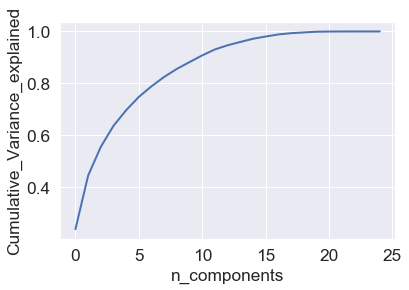

PCA Done! Time elapsed: 0.3558468818664551 seconds


In [465]:
#Explained Variance Plot for choosing # Components
time_start = time.time()
pca=PCA()  
pca.n_components=25 
pca_data=pca.fit_transform(X)
percentage_var_explained = pca.explained_variance_ratio_;  
cum_var_explained=np.cumsum(percentage_var_explained)
#plot PCA spectrum 
plt.figure(1,figsize=(6,4))
plt.grid()
plt.clf()
plt.plot(cum_var_explained,linewidth=2)  
plt.axis('tight')  
plt.xlabel('n_components') 
plt.ylabel('Cumulative_Variance_explained')  
plt.show()
print ('PCA Done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [466]:
#Define 15 components 
time_start = time.time()
pca=PCA(n_components=15) 
principalComponents=pca.fit_transform(X) 
principalDf=pd.DataFrame(data=principalComponents,columns=[
    'PC 1',
    'PC 2',
    'PC 3',
    'PC 4',
    'PC 5',
    'PC 6',
    'PC 7',
    'PC 8',
    'PC 9',
    'PC 10',
    'PC 11',
    'PC 12',
    'PC 13',
    'PC 14',
    'PC 15']) 
principalDf.head()
print ('PCA Done! Time elapsed: {} seconds'.format(time.time()-time_start))

PCA Done! Time elapsed: 0.01422882080078125 seconds


In [467]:
#Add Labels to PC df
finalDf=pd.concat([principalDf,df['label']],axis=1)
finalDf.tail()

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10,PC 11,PC 12,PC 13,PC 14,PC 15,label
1496,1.366138,-3.476818,0.267699,0.041942,0.748632,-0.810898,0.554574,-1.348295,0.041887,-0.353683,-0.005128,0.474973,-0.465260,-1.034869,1.353872,19
1497,-0.883138,0.282786,-1.579071,-1.117713,-0.963353,0.747915,-1.211684,0.872109,0.427240,0.635956,-0.193604,-1.121965,-0.277382,0.117742,0.095842,19
1498,-1.071218,-0.103350,0.261372,3.528635,0.118141,-0.959686,1.181325,1.139758,-0.664052,-0.106220,-0.337132,0.508893,0.682339,0.037088,-0.546053,19
1499,-2.989646,5.193919,0.179034,-0.212512,-0.933524,1.206028,-0.019431,-0.379748,-2.328447,-0.327492,-0.136613,0.137949,-0.094018,0.088114,0.022051,19
1500,-1.014473,0.968537,-1.690173,-0.350475,-0.522179,0.898339,0.266139,-0.107055,0.193191,-0.459344,0.308715,-0.168022,0.063729,0.256902,-0.083158,19


In [468]:
#Total Explained Variance
print('PCA Explained Variance Ratio {}'.format(sum(pca.explained_variance_ratio_)))

PCA Explained Variance Ratio 0.9719117159611107


PC1 & PC2 Explained Variance Ratio 0.44553185592847033


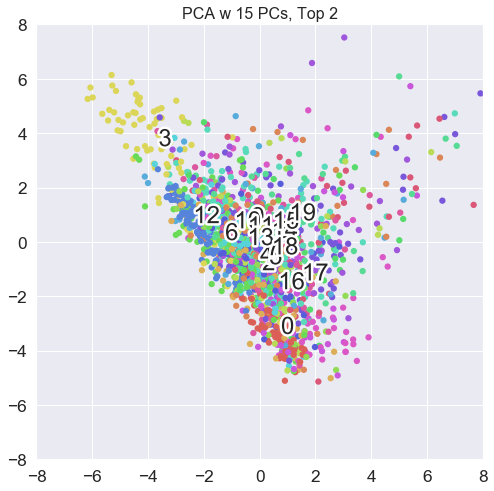

In [333]:
top_two_PC = finalDf[['PC 1','PC 2']]
print('PC1 & PC2 Explained Variance Ratio {}'.format(sum(pca.explained_variance_ratio_[0:2])))
scatter('PCA w 15 PCs, Top 2',top_two_PC.values,y,8)

**PCA with 15 Components explains ~97% of the data variance.**

<h3> TSNE: Dimensionality Reduction </h3>

In [276]:
import numpy as np
from sklearn.datasets import load_digits
# from sklearn.datasets import get_x_y
from scipy.spatial.distance import pdist
from sklearn.manifold.t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)

In [277]:
from sklearn.utils import shuffle
from sklearn.manifold import TSNE


In [336]:
time_start = time.time()
tsne = TSNE()
X_embedded = TSNE(random_state=24).fit_transform(X)
print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 12.394967079162598 seconds


In [308]:
# TSNE/PCA time
71.11765313148499/0.012228965759277344

5815.508402869843

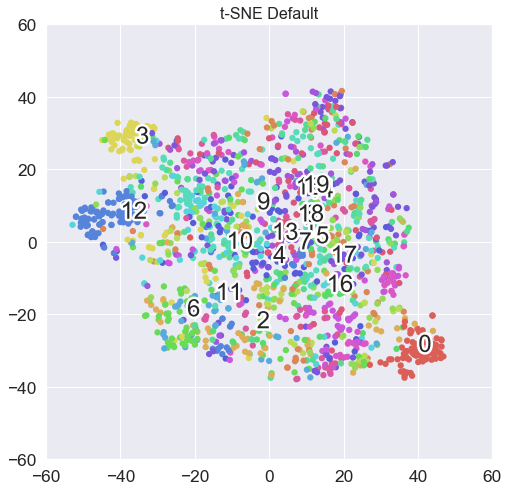

In [337]:
scatter('t-SNE Default',X_embedded, y,60)

t-SNE done! Time elapsed: 10.858057975769043 seconds


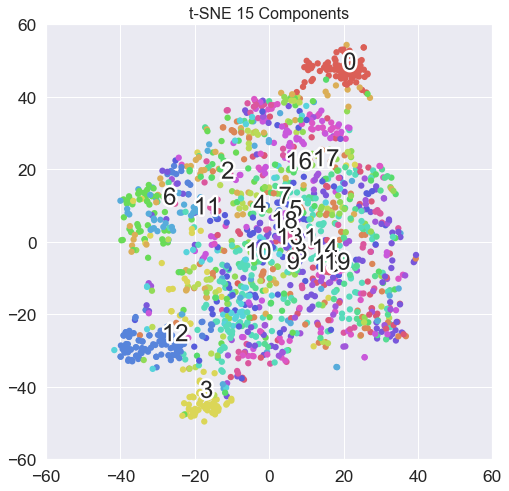

In [403]:
time_start = time.time()
tsne = TSNE(n_components=15)
X_embedded = TSNE(random_state=24).fit_transform(X)
print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
scatter('t-SNE 15 Components',X_embedded, y,60)

<h4> t-SNE Parameter Tuning </h4>

perplexity=5 in 9.1 sec
perplexity=10 in 10 sec
perplexity=15 in 14 sec
perplexity=20 in 14 sec
perplexity=25 in 12 sec
perplexity=30 in 17 sec
perplexity=35 in 17 sec
perplexity=40 in 14 sec
perplexity=45 in 13 sec


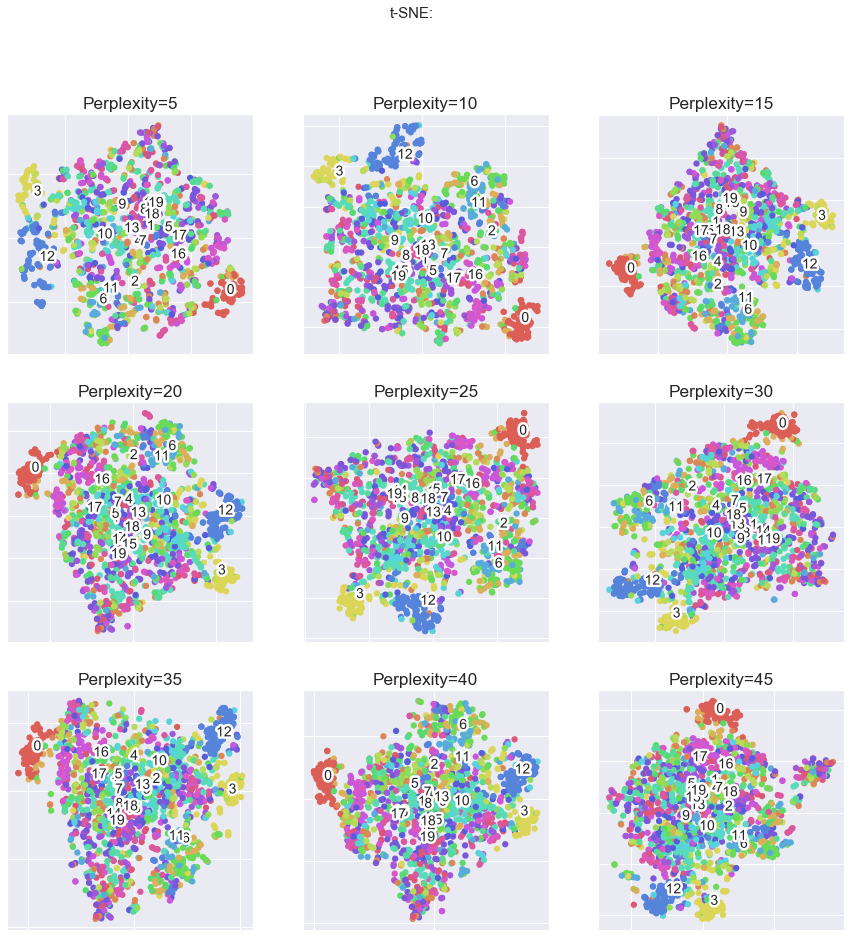

In [454]:
# Perplexities: Run + Plot t-SNE with varying perplexities 
from matplotlib.ticker import NullFormatter

fig = plt.figure(figsize=(15, 15))
plt.suptitle("t-SNE:", size=15)

colors=y
num_classes = len(np.unique(colors))
palette = np.array(sns.color_palette("hls", num_classes))

perplexities = list(np.arange(5,50,5))
axs = []
for i, perplexity in enumerate(perplexities):
    
    ax = fig.add_subplot(33*10+(i+1)) 
    t0 = time.time()
    tsne = TSNE(init='random',
                         random_state=24, perplexity=perplexity)
    transformed = tsne.fit_transform(X)
    t1 = time.time()
    print("perplexity=%d in %.2g sec" % (perplexity, t1 - t0))
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(transformed[:,0], transformed[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    axs.append(ax)
#     plt.show();
    txts = []
    for i in range(num_classes):
        # Position of each label at median of data points for that label.
        xtext, ytext = np.median(transformed[y == i, :], axis=0);
        txt = ax.text(xtext, ytext, str(i), fontsize=14);
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()]);
        txts.append(txt); 
        
for ax in axs:
    plt.show();


perplexity=5 in 44 sec
perplexity=10 in 44 sec
perplexity=15 in 50 sec
perplexity=20 in 49 sec
perplexity=25 in 52 sec
perplexity=30 in 43 sec
perplexity=35 in 52 sec
perplexity=40 in 31 sec
perplexity=45 in 52 sec


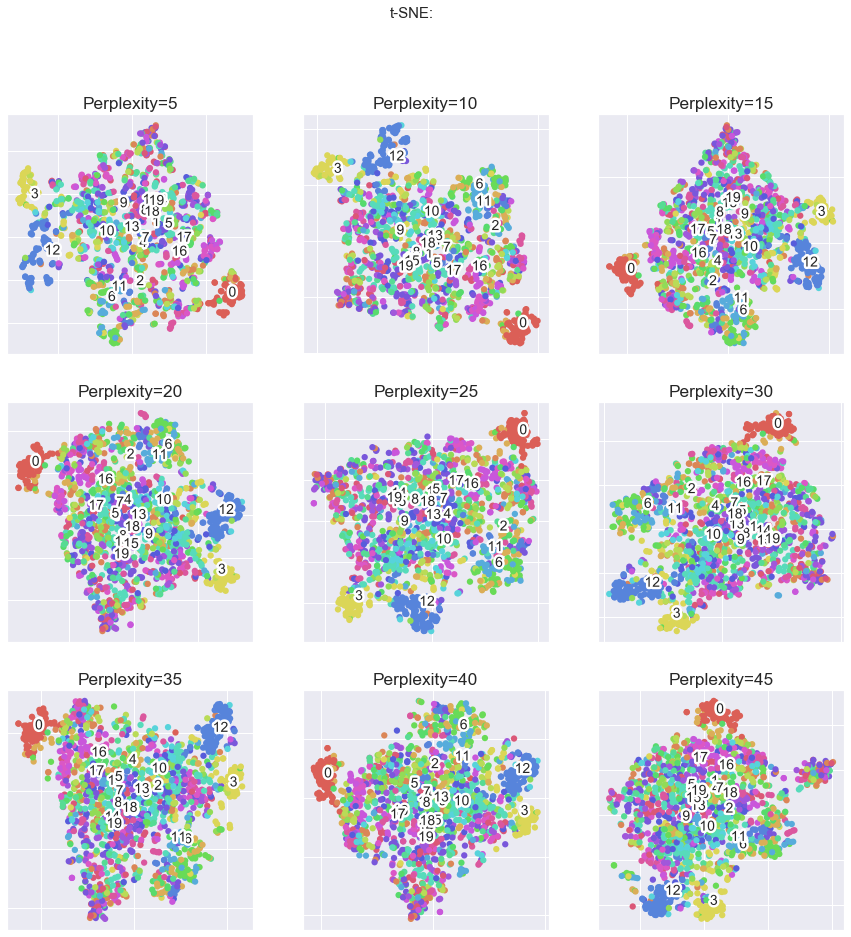

In [455]:
# Perplexities: Run + Plot t-SNE with varying perplexities 
from matplotlib.ticker import NullFormatter

fig = plt.figure(figsize=(15, 15))
plt.suptitle("t-SNE:", size=15)

colors=y
num_classes = len(np.unique(colors))
palette = np.array(sns.color_palette("hls", num_classes))

perplexities = list(np.arange(5,50,5))
axs = []
for i, perplexity in enumerate(perplexities):
    
    ax = fig.add_subplot(33*10+(i+1)) 
    t0 = time.time()
    tsne = TSNE(init='random',
                         random_state=24, perplexity=perplexity, n_iter=5000)
    transformed = tsne.fit_transform(X)
    t1 = time.time()
    print("perplexity=%d in %.2g sec" % (perplexity, t1 - t0))
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(transformed[:,0], transformed[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    axs.append(ax)
#     plt.show();
    txts = []
    for i in range(num_classes):
        # Position of each label at median of data points for that label.
        xtext, ytext = np.median(transformed[y == i, :], axis=0);
        txt = ax.text(xtext, ytext, str(i), fontsize=14);
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()]);
        txts.append(txt); 
        
for ax in axs:
    plt.show();


In [310]:
#t-SNE, post 15 Component PCA
time_start = time.time()
tsne = TSNE()
X_embedded = TSNE(random_state=24).fit_transform(principalComponents)
print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 13.717819929122925 seconds


perplexity=5 in 55 sec
perplexity=10 in 57 sec
perplexity=15 in 57 sec
perplexity=20 in 59 sec
perplexity=25 in 53 sec
perplexity=30 in 56 sec
perplexity=35 in 55 sec
perplexity=40 in 53 sec
perplexity=45 in 46 sec


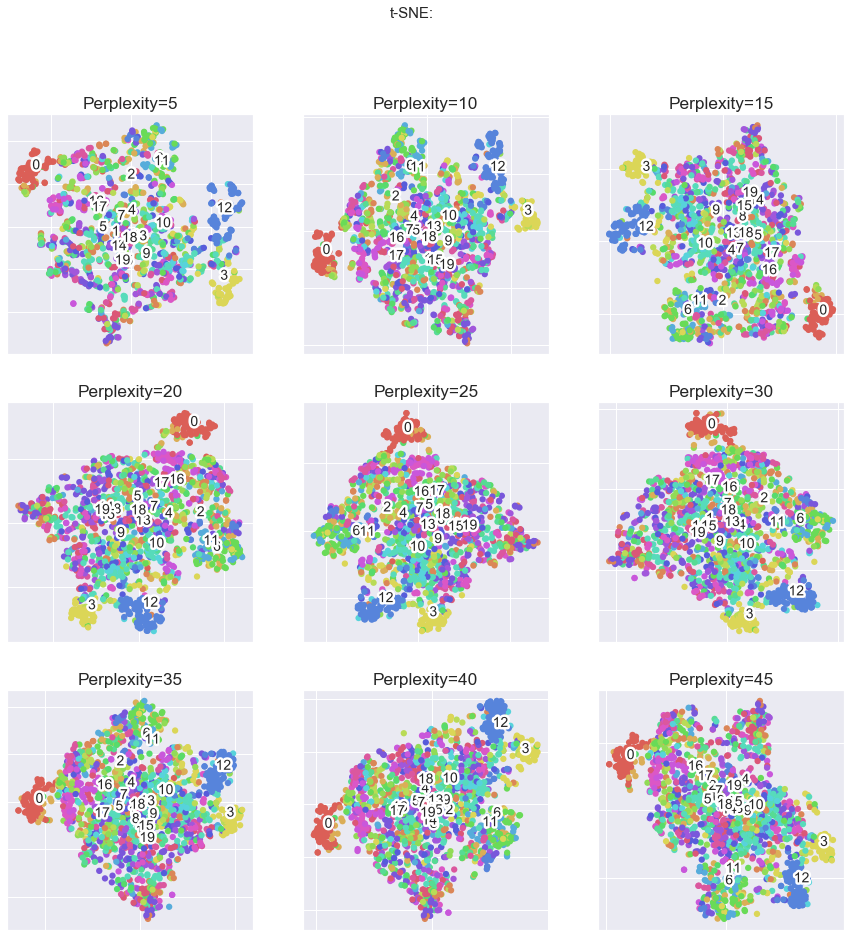

In [469]:
# Run t-SNE post PCA with 15 PCs
from matplotlib.ticker import NullFormatter

fig = plt.figure(figsize=(15, 15))
plt.suptitle("t-SNE:", size=15)

colors=y
num_classes = len(np.unique(colors))
palette = np.array(sns.color_palette("hls", num_classes))

perplexities = list(np.arange(5,50,5))
axs = []
for i, perplexity in enumerate(perplexities):
    
    ax = fig.add_subplot(33*10+(i+1)) 
    t0 = time.time()
    tsne = TSNE(init='random',
                         random_state=24, perplexity=perplexity, n_iter=5000)
    transformed = tsne.fit_transform(principalComponents)
    t1 = time.time()
    print("perplexity=%d in %.2g sec" % (perplexity, t1 - t0))
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(transformed[:,0], transformed[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    axs.append(ax)
#     plt.show();
    txts = []
    for i in range(num_classes):
        # Position of each label at median of data points for that label.
        xtext, ytext = np.median(transformed[y == i, :], axis=0);
        txt = ax.text(xtext, ytext, str(i), fontsize=14);
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()]);
        txts.append(txt); 
        
for ax in axs:
    plt.show();


t-SNE done! Time elapsed: 13.104672908782959 seconds


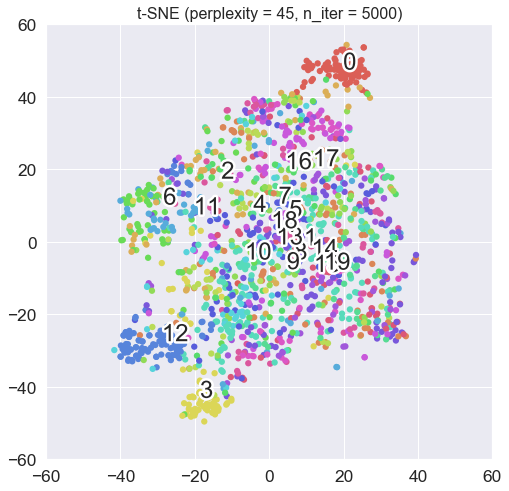

In [460]:
#Best t-SNE: 
time_start = time.time()
tsne = TSNE(init='random',
                         random_state=24, perplexity=45, n_iter=5000)
X_embedded = TSNE(random_state=24).fit_transform(X)
print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
scatter('t-SNE (perplexity = 45, n_iter = 5000)',X_embedded, y,60)

## SANDBOX

In [113]:
cv2.__version__

'3.4.2'

In [114]:
skimage.__version__

'0.15.0'

https://apassionatechie.wordpress.com/2017/12/27/create-multiple-pandas-dataframe-columns-from-applying-a-function-with-multiple-returns/

In [ ]:
#5,000
time_start = time.time()
tsne = TSNE(n_components=15, n_iter=5000)
X_embedded = TSNE(random_state=24).fit_transform(X)
print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
scatter('t-SNE 15 Components',X_embedded, y,60)